In [2]:
using Revise, NeuralNetworkAnalysis, JLD2, Plots, DifferentialEquations
const NNA = NeuralNetworkAnalysis
const RA = ReachabilityAnalysis

ReachabilityAnalysis

In [7]:
controller = NNA.read_nnet_mat("/home/sguadalupe/.julia/dev/NeuralNetworkAnalysis/models/Sherlock-Benchmark-10-Unicycle/controllerB_nnv.mat", act_key="act_fcns");

Network(NeuralVerification.Layer[NeuralVerification.Layer{NeuralVerification.ReLU,Float64}([-0.036691424 -0.0033654752 -0.12826693 0.044926044; -0.20031829 0.06782837 -0.05676763 -0.09363357; … ; -0.017800266 0.1421798 0.14203101 0.008427695; 0.12882262 0.09967732 0.047212083 -0.16629672], [0.027661305, 0.0733482, 0.53262377, 0.38446143, 0.36500773, 0.38786823, 0.42982906, 0.35634315, -0.013301703, 0.32666638  …  0.052498974, 0.34985837, 0.3458436, 0.33031547, 0.35691723, 0.35302645, 0.37814328, 0.3322429, 0.23190033, 0.3417574], NeuralVerification.ReLU()), NeuralVerification.Layer{NeuralVerification.ReLU,Float64}([0.052072976 -0.1397791 … 0.22964926 0.19975664; -0.13757132 0.07203197 … 0.044258755 0.15406653], [0.2730041, 0.30427453], NeuralVerification.ReLU())])

In [29]:
@taylorize function benchmark10!(dx, x, p, t)
    x₁, x₂, x₃, x₄, u₁, u₂, w = x
    dx[1] = x₄ * cos(x₃)
    dx[2] = x₄ * sin(x₃)
    dx[3] = u₂
    dx[4] = u₁ + w
    dx[5] = zero(x[7]) # w
    dx[6] = zero(x[5]) # u₁
    dx[7] = zero(x[6]) # u₂
    return dx
end

In [79]:
X₀ = Hyperrectangle(low=[9.5, -4.5, 2.1, 1.5], high=[9.55, -4.45, 2.11, 1.51])
W₀ = ZeroSet(1)#Hyperrectangle(low=[-1e-4], high=[1e-4])
U₀ = Universe(2)
prob = @ivp(x' = benchmark10!(x), dim: 7, x(0) ∈ X₀ × W₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[5], :control_vars=>[6:7]);
using NeuralNetworkAnalysis: UniformAdditiveNormalization
UAN = UniformAdditiveNormalization(-20.0)
plant = ControlledPlant(prob, controller, vars_idx, 1.0, UAN);

In [80]:
simulations, controls, inputs = NeuralNetworkAnalysis.simulate(plant, T=20.0, trajectories=1);

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/sguadalupe/.julia/packages/SciMLBase/eghDQ/src/integrator_interface.jl:328
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/sguadalupe/.julia/packages/SciMLBase/eghDQ/src/integrator_interface.jl:328
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/sguadalupe/.julia/packages/SciMLBase/eghDQ/src/integrator_interface.jl:328
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/sguadalupe/.julia/packages/SciMLBase/eghDQ/src/integrator_interface.jl:328
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/sguadalupe/.julia/packages/SciMLBase/eghDQ/src/integrator_interface.jl:328


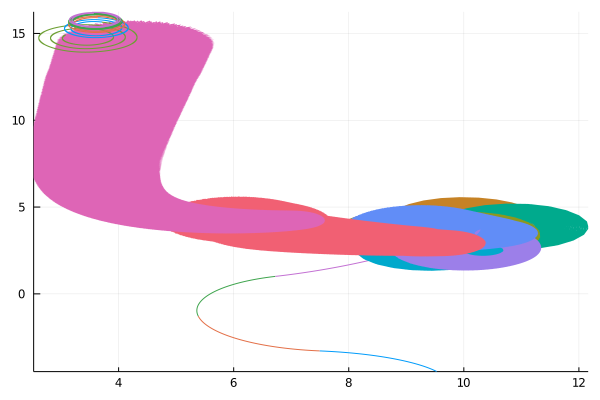

In [81]:
using Plots
fig = plot()
for simulation in simulations
    plot!(fig, simulation, vars=(1, 2), fmt=:png)
end
fig